# Processing of Momeni masks

In [1]:
!pip install -e /home/cerebriu/data/RESEARCH/MicrobleedNet/
import nibabel as nib
import nilearn as nil
import numpy as np 
import sys
from scipy.cluster.hierarchy import fcluster, linkage
from scipy.spatial.distance import pdist

import cmbnet.preprocessing.loading as utils_datasets
from cmbnet.preprocessing.datasets.momeni import load_MOMENI_raw, process_MOMENI_anno, load_MOMENI_data
import cmbnet.visualization.utils_plotting as utils_plt
import os
from typing import Tuple, List, Dict
import matplotlib.pyplot as plt


import importlib
import cmbnet
importlib.reload(cmbnet)


Obtaining file:///home/cerebriu/data/RESEARCH/MicrobleedNet
  Preparing metadata (setup.py) ... done
  Attempting uninstall: cmbnet
    Found existing installation: cmbnet 2.0
    Uninstalling cmbnet-2.0:
      Successfully uninstalled cmbnet-2.0
  Running setup.py develop for cmbnet

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


<module 'cmbnet' from '/home/cerebriu/data/RESEARCH/MicrobleedNet/cmbnet/__init__.py'>

In [2]:
input_dir = "/home/cerebriu/data/datasets/raw/MOMENI"
subjects = utils_datasets.get_dataset_subjects("momeni", input_dir)

In [3]:
def adjust_for_radiological_view(image: np.ndarray) -> np.ndarray:
    """
    Adjusts the image for the radiological view by rotating it 90 degrees clockwise.
    """
    return np.rot90(image)

def plot_cross_with_gap(ax, x, y, color='r', gap_size=5, line_length=10, **kwargs):
    """
    Draws a cross on the plot with a specified gap around the center, accounting for y-axis inversion.

    Args:
        ax: The axis on which to draw.
        x, y: The center coordinates of the cross, considering y-axis inversion.
        width, height: The width and height of the plotting area, used for y-axis inversion.
        color: The color of the cross.
        gap_size: The size of the gap around the center.
        line_length: The length of each line of the cross.
    """
    # Vertical line (adjustment only needed for y-axis inversion)
    ax.plot([x, x], [y - gap_size - line_length, y - gap_size], color=color, **kwargs)
    ax.plot([x, x], [y + gap_size, y + gap_size + line_length], color=color, **kwargs)
    
    # Horizontal line
    ax.plot([x - gap_size - line_length, x - gap_size], [y, y], color=color, **kwargs)
    ax.plot([x + gap_size, x + gap_size + line_length], [y, y], color=color, **kwargs)


import matplotlib.pyplot as plt

def plot_processed_mask(mri_data, cmb_data, out_mask, cmb_coords, sequence_type, zoom_size, save_path=None):

    half_size = zoom_size / 2

    # Calculate the start and end indices for the crop
    start_idx = [max(0, int(cm - half_size)) for cm in cmb_coords]
    end_idx = [min(dim, int(cm + half_size)) for cm, dim in zip(cmb_coords, mri_data.shape)]

    # Create slices for cropping
    crop_slice = tuple(slice(start, end) for start, end in zip(start_idx, end_idx))

    # Apply cropping
    t2s_data_cropped = mri_data[crop_slice]
    cmb_cropped = cmb_data[crop_slice]
    pred_cmb_cropped = out_mask[crop_slice]

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # 2x2 layout
    
    x_whole=cmb_coords[0]
    y_whole=mri_data.shape[1] - cmb_coords[1]

    # Plot original and generated masks with cross
    for ax, img, title in zip(axs[1, :], [cmb_cropped, pred_cmb_cropped], ['Original Mask', 'Generated Mask']):
        ax.imshow(adjust_for_radiological_view(t2s_data_cropped[:, :, cmb_coords[-1]]), cmap='gray')  # Use the MRI image as the background for both plots
        ax.imshow(adjust_for_radiological_view(img[:, :, cmb_coords[-1]]), alpha=0.5, cmap="Reds")  # Overlay mask or generated mask
        # Plot cross at the new center position
        plot_cross_with_gap(ax, y=t2s_data_cropped.shape[0] / 2, x=t2s_data_cropped.shape[1] / 2, color='yellow', line_length=25, gap_size=15, linewidth=1)
        ax.set_title(title)

    # Plot the full view without zoom
    axs[0, 0].imshow(adjust_for_radiological_view(mri_data[:, :, cmb_coords[-1]]), cmap='gray')
    plot_cross_with_gap(axs[0, 0], x=x_whole, y=y_whole, color='yellow', line_length=25, gap_size=15, linewidth=1)
    axs[0, 0].set_title('Full View')

    # Plot the full view with zoom
    axs[0, 1].imshow(adjust_for_radiological_view(t2s_data_cropped[:, :, cmb_coords[-1]]), cmap='gray')  
    plot_cross_with_gap(axs[0, 1], y=t2s_data_cropped.shape[0] / 2, x=t2s_data_cropped.shape[1] / 2, color='yellow', line_length=25, gap_size=15, linewidth=1)

    # for ax in axs.ravel():
    #     ax.axis('off')

    if save_path:
        plt.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()


------------------------------------------------
239_T1_MRI_SWI_BFC_50mm_HM
------------------------------------------------
[(54, 116, 40), (47, 161, 38)]


Looping over tolerances:   1%|          | 20/2000 [00:00<01:14, 26.60it/s]


		Thresholds for RegionGrowing --> Max. distance =5, Max Size=340
		Processing CMB annotations 
		Processed CMB 0. center of mass=(54, 116, 40), new_size=1
		Processed CMB 1. center of mass=(47, 161, 38), new_size=1

shape: (176, 256, 80)
(54, 116, 40)


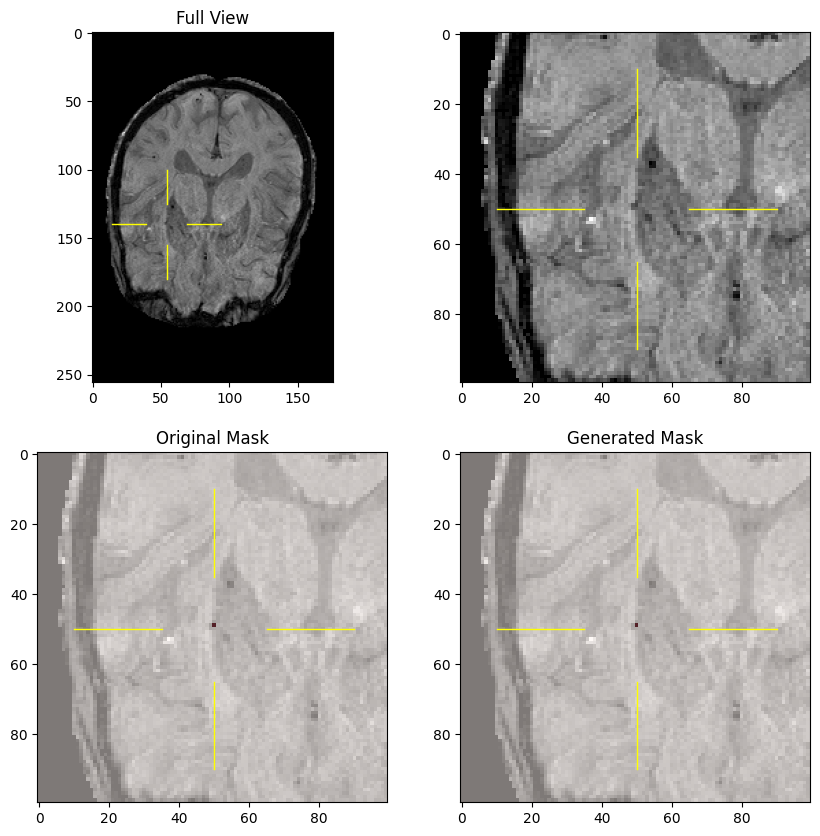

(47, 161, 38)


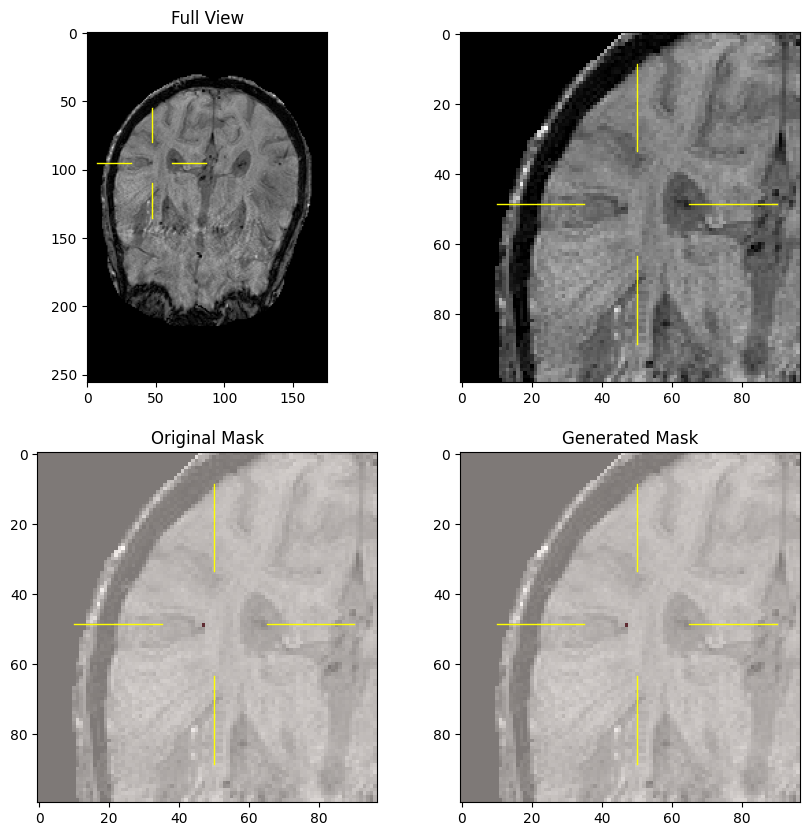

------------------------------------------------
273_T2_MRI_SWI_BFC_50mm_HM
------------------------------------------------
[(41, 167, 51), (65, 199, 32), (64, 183, 35), (124, 186, 34), (130, 103, 54)]


Looping over tolerances:   1%|          | 20/2000 [00:00<01:11, 27.50it/s]


		Thresholds for RegionGrowing --> Max. distance =5, Max Size=340
		Processing CMB annotations 
		Processed CMB 0. center of mass=(41, 167, 51), new_size=1
		Processed CMB 1. center of mass=(65, 199, 32), new_size=1
		Processed CMB 2. center of mass=(64, 183, 35), new_size=1
		Processed CMB 3. center of mass=(124, 186, 34), new_size=1
		Processed CMB 4. center of mass=(130, 103, 54), new_size=1

shape: (176, 256, 80)
(41, 167, 51)


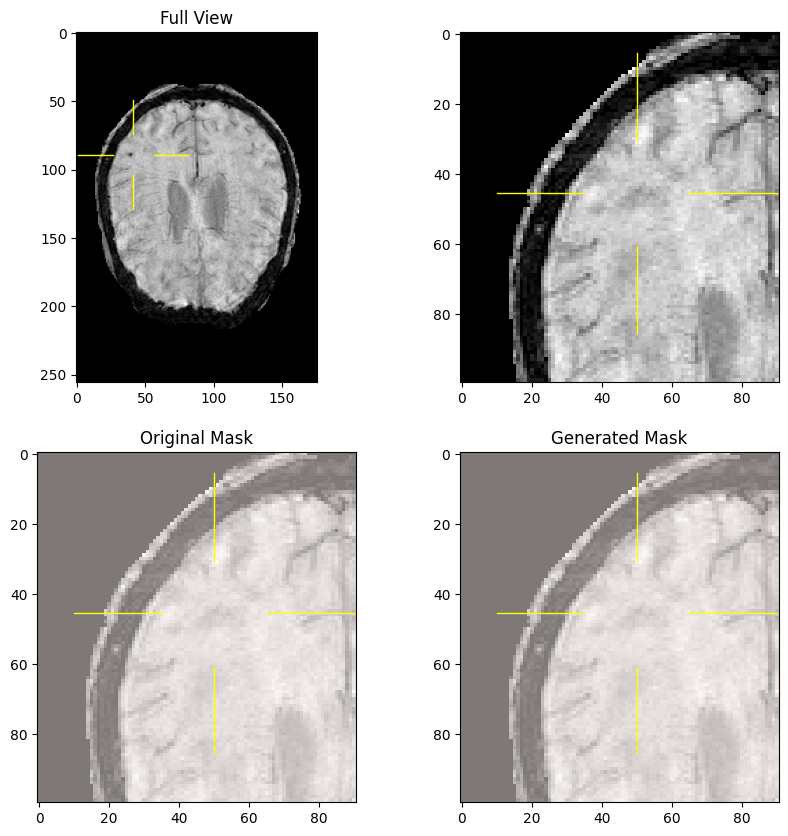

(65, 199, 32)


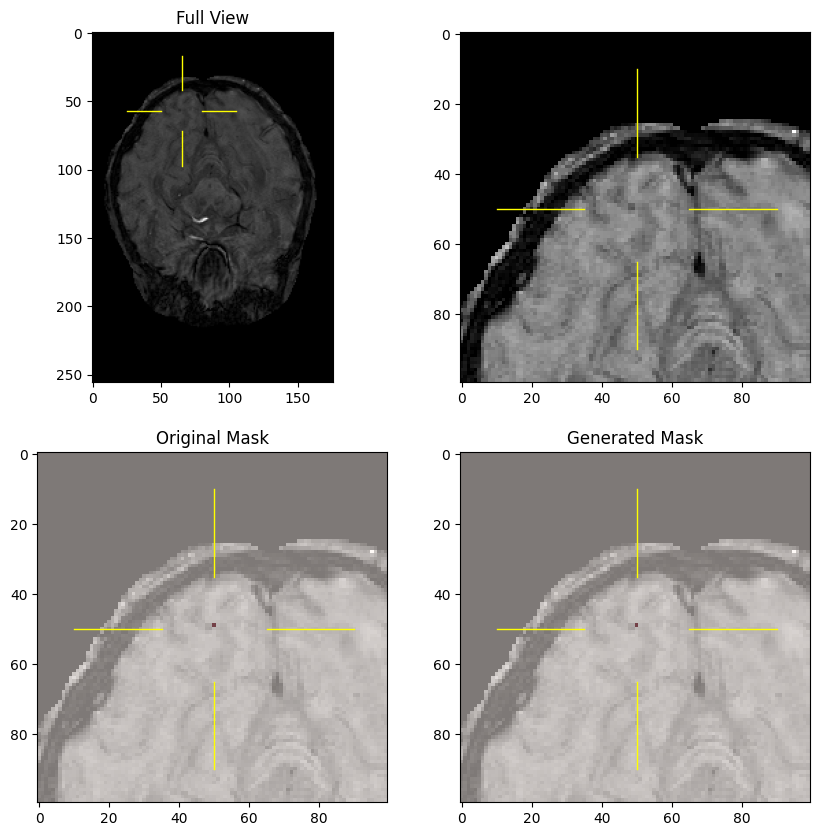

(64, 183, 35)


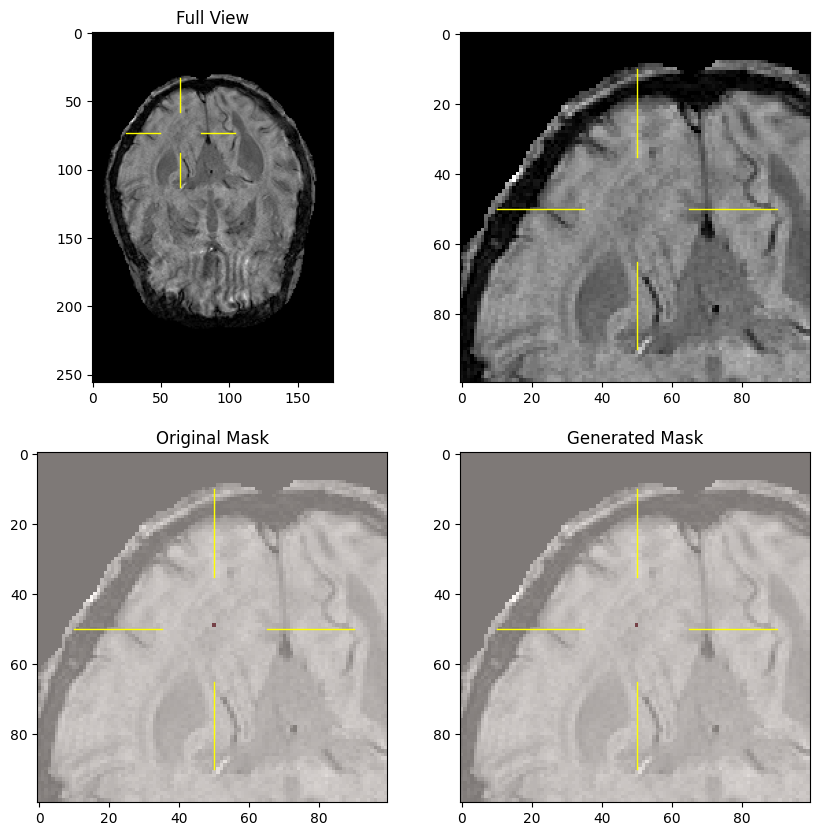

(124, 186, 34)


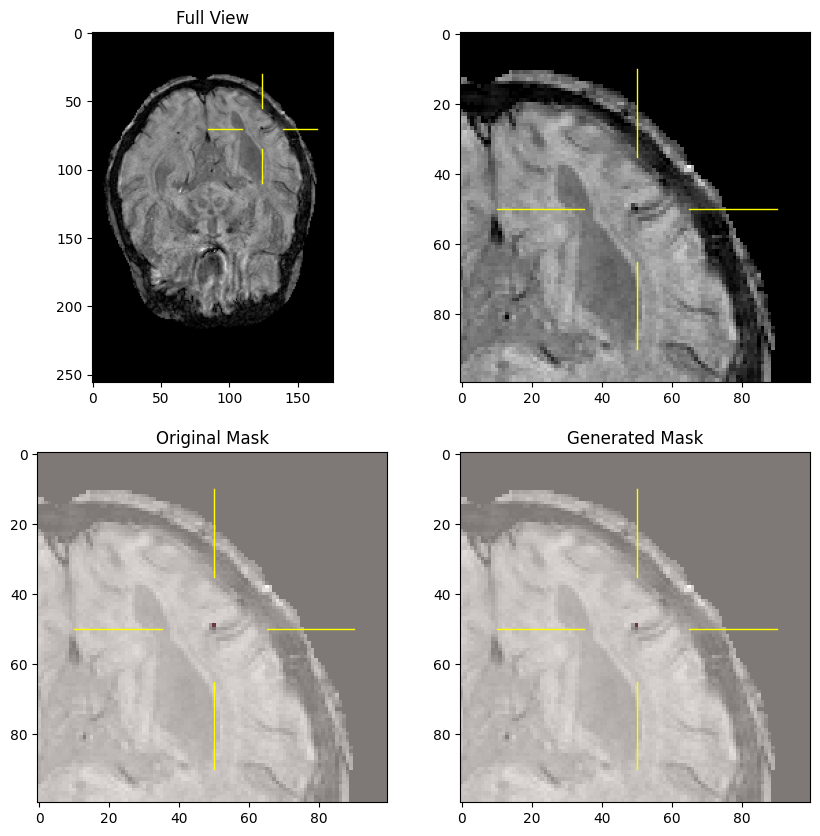

(130, 103, 54)


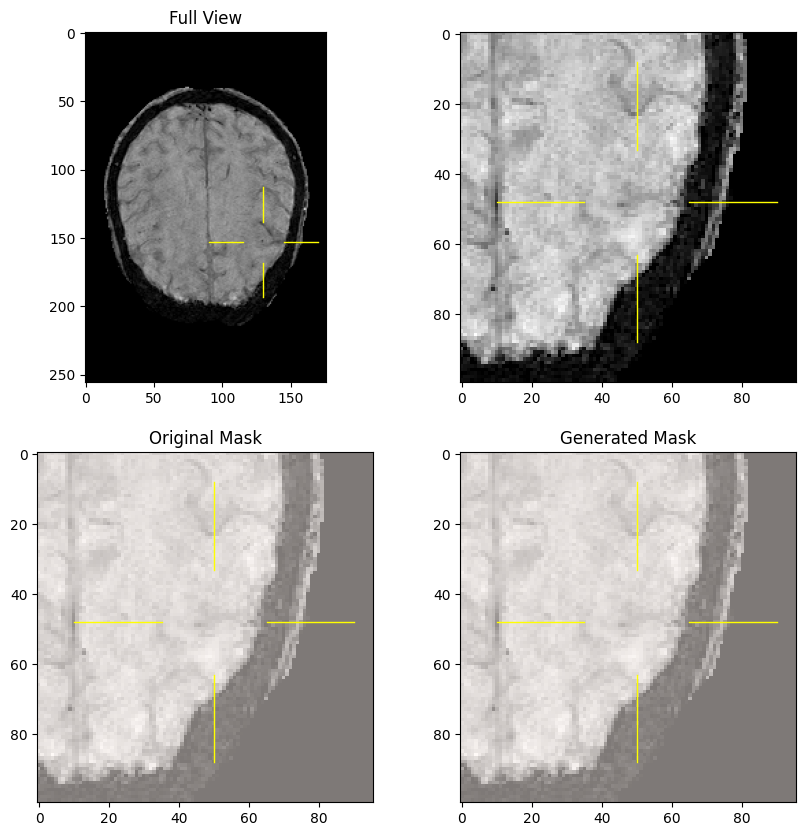

------------------------------------------------
294_T2_MRI_SWI_BFC_50mm_HM
------------------------------------------------
[(116, 165, 19), (35, 147, 56)]


Looping over tolerances:   1%|          | 20/2000 [00:00<01:15, 26.26it/s]


		Thresholds for RegionGrowing --> Max. distance =5, Max Size=340
		Processing CMB annotations 
		Processed CMB 0. center of mass=(116, 165, 19), new_size=1
		Processed CMB 1. center of mass=(35, 147, 56), new_size=1

shape: (176, 256, 80)
(116, 165, 19)


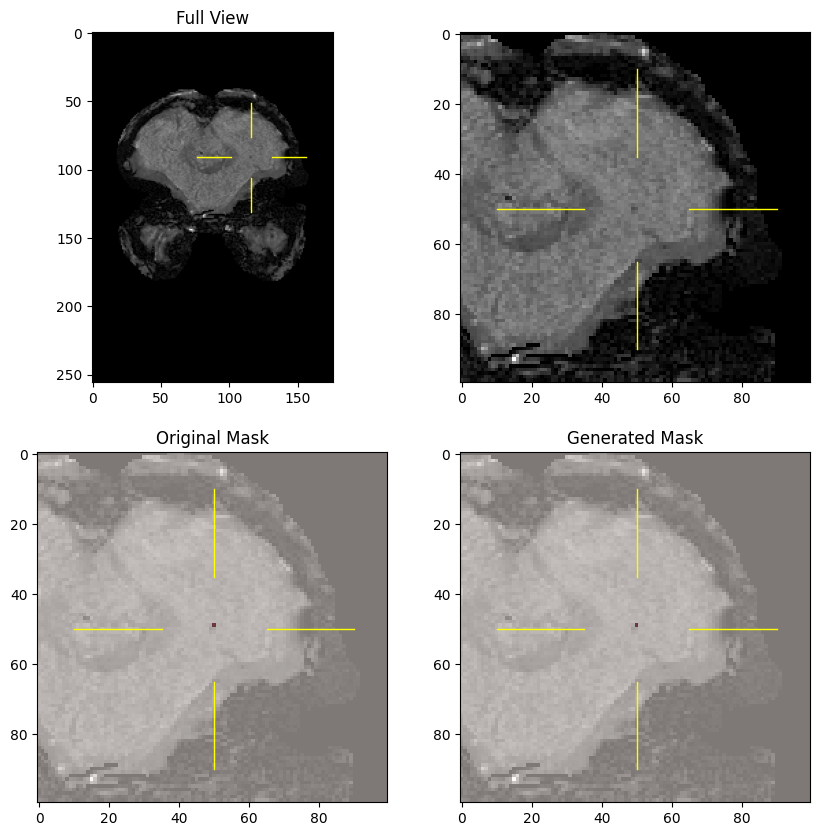

(35, 147, 56)


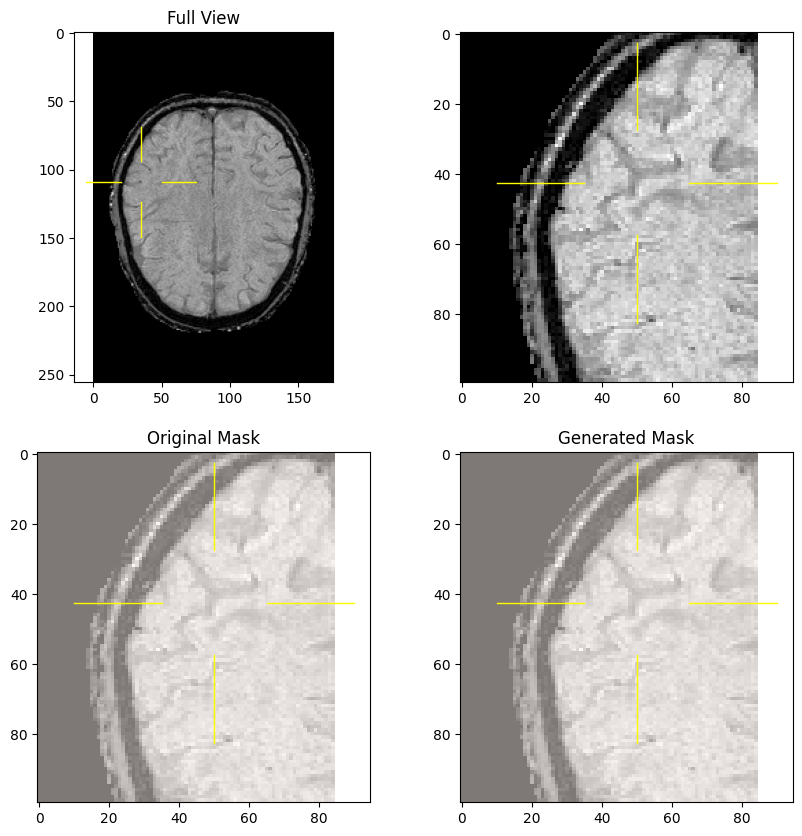

------------------------------------------------
276_T0_MRI_SWI_BFC_50mm_HM
------------------------------------------------
[(125, 188, 45)]


Looping over tolerances:   1%|          | 20/2000 [00:00<01:22, 23.97it/s]


		Thresholds for RegionGrowing --> Max. distance =5, Max Size=340
		Processing CMB annotations 
		Processed CMB 0. center of mass=(125, 188, 45), new_size=1

shape: (176, 256, 80)
(125, 188, 45)


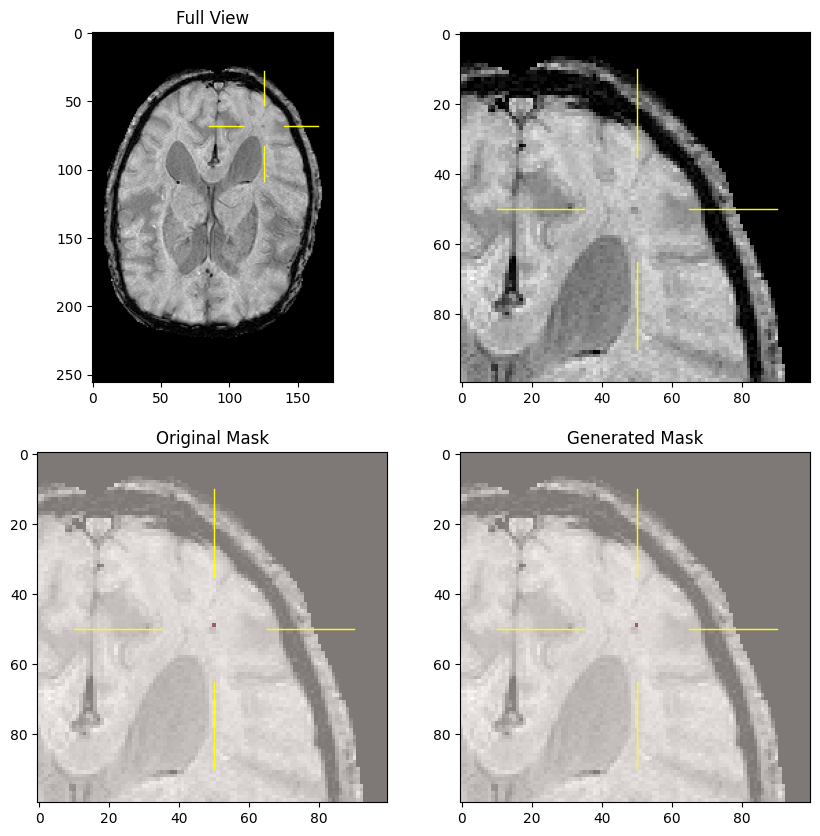

------------------------------------------------
274_T2_MRI_SWI_BFC_50mm_HM
------------------------------------------------
[(102, 64, 48)]


Looping over tolerances:   1%|          | 20/2000 [00:00<01:23, 23.59it/s]


		Thresholds for RegionGrowing --> Max. distance =5, Max Size=340
		Processing CMB annotations 
		Processed CMB 0. center of mass=(102, 64, 48), new_size=1

shape: (176, 256, 80)
(102, 64, 48)


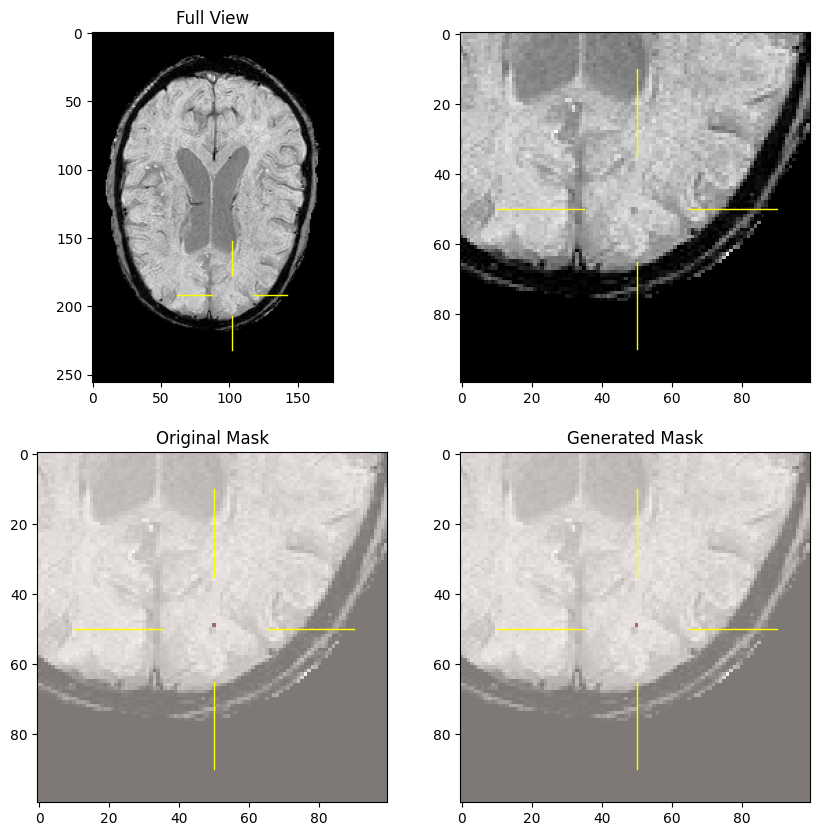

------------------------------------------------
222_T1_MRI_SWI_BFC_50mm_HM
------------------------------------------------
[(67, 219, 32), (93, 76, 64), (86, 100, 65)]


Looping over tolerances:   1%|          | 20/2000 [00:00<01:24, 23.34it/s]


		Thresholds for RegionGrowing --> Max. distance =5, Max Size=340
		Processing CMB annotations 
		Processed CMB 0. center of mass=(67, 219, 32), new_size=1
		Processed CMB 1. center of mass=(93, 76, 64), new_size=1
		Processed CMB 2. center of mass=(86, 100, 65), new_size=1

shape: (176, 256, 80)
(67, 219, 32)


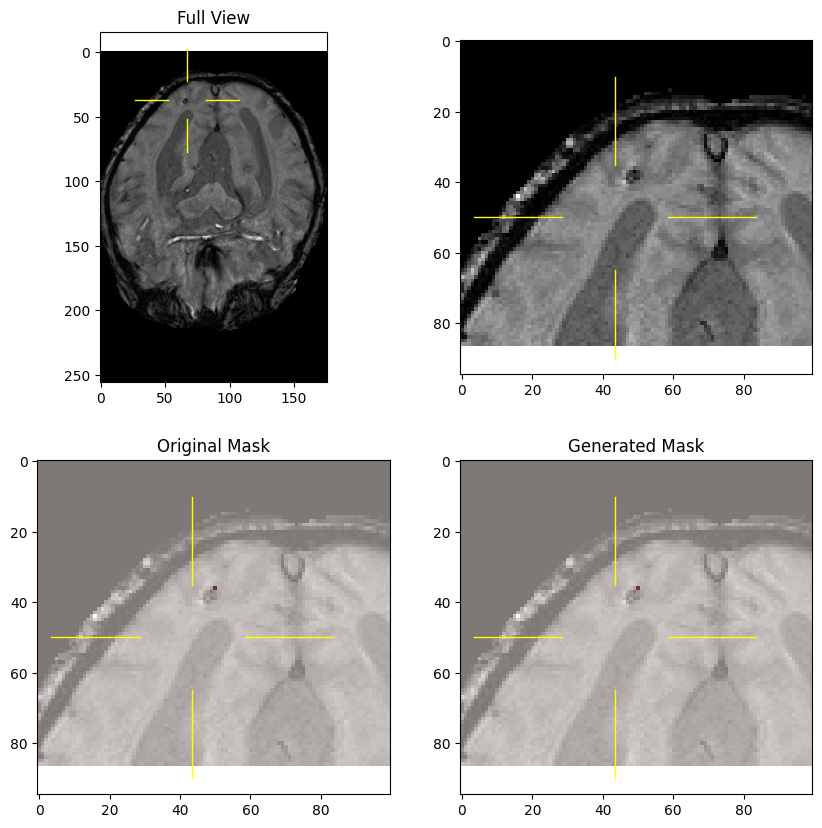

(93, 76, 64)


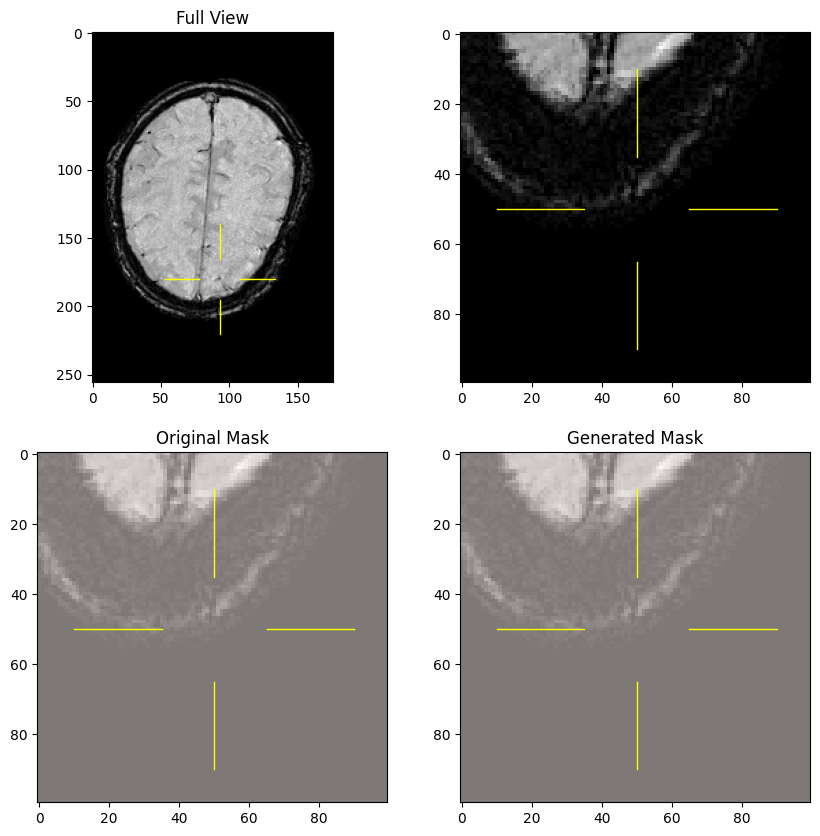

(86, 100, 65)


IndexError: index 65 is out of bounds for axis 2 with size 65

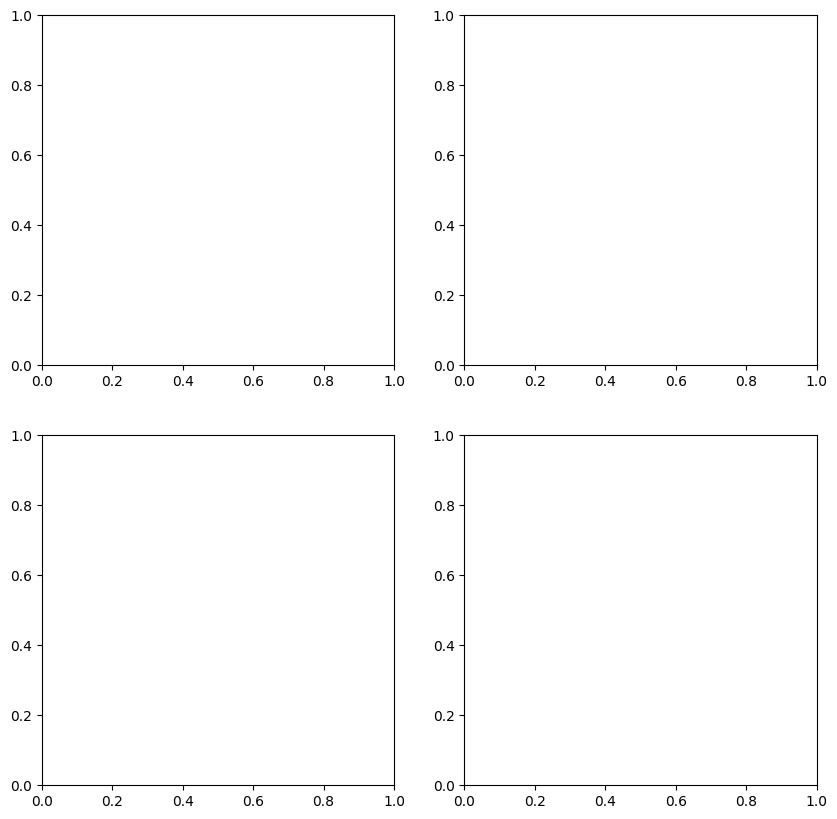

In [4]:
for subject in subjects:
    print("------------------------------------------------")
    print(subject)
    print("------------------------------------------------")

    # Load data
    sequences_raw, labels_raw, sequence_type, centersofmass = load_MOMENI_raw(input_dir, subject)

    print(centersofmass)
    sequences_qc, labels_qc, labels_metadata, sequence_type, msg = load_MOMENI_data(None, input_dir, subject, "")
    print(msg)

    # Prepare data for plotting
    im1 = sequences_qc[sequence_type].get_fdata()
    cmb1 = labels_raw[sequence_type].get_fdata()
    grown_mask = labels_qc[sequence_type].get_fdata()

    print(f"shape: {im1.shape}")

    # Plotting processed masks for each center of mass
    for i, CM in enumerate(centersofmass):
        print(CM)
        plot_processed_mask(im1, cmb1, grown_mask, CM, sequence_type, 100
                                        
                                        )
